In [2]:
from google.colab import drive 
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
#from helper_functions import calculate_results
import numpy as np
import tensorflow as tf
import tensorflow
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from keras.models import *

data_dir = "drive/MyDrive/claim-data/pubmed-rct-master/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir +filename for filename in os.listdir(data_dir)]

def get_lines(filename):
  """
  """
  with open(filename, "r") as f:
    return f.readlines()

train_lines = get_lines(filenames[2])
train_lines[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

180040 30212 30135
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64
180040 30212 30135


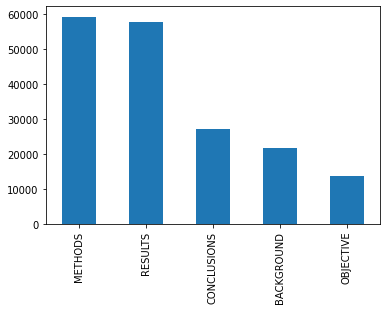

In [4]:

def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)  # get all lines from filename
    abstract_lines = ""  # create an empty abstract
    abstract_samples = []  # create an empty list of abstracts

    for line in input_lines:
        if line.startswith("###"):  # check to see if line is an ID line
            abstract_id = line
            abstract_lines = ""  # reset the abstract string
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()  # split the abstract into separate lines

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)

        else:
            abstract_lines += line

    return abstract_samples

# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

# Distribution of labels in training dat
print(train_df["target"].value_counts())

train_df["target"].value_counts().plot(kind = 'bar')

# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

train_labels= train_df["target"].to_numpy().reshape(-1, 1)
val_labels= val_df["target"].to_numpy().reshape(-1, 1)
test_labels= test_df["target"].to_numpy().reshape(-1, 1)

print(len(train_sentences), len(val_sentences), len(test_sentences))

In [5]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 29.0 MB/s 
     |████████████████████████████████| 77 kB 8.4 MB/s 
     |████████████████████████████████| 6.6 MB 69.2 MB/s 
     |████████████████████████████████| 53 kB 1.3 MB/s 
     |████████████████████████████████| 11.2 MB 55.3 MB/s 
     |████████████████████████████████| 930 kB 81.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [6]:
np.unique(train_labels)

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [7]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, 
                          AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, 
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )
 
 
# Set seed for reproducibility,
set_seed(123)
 
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
 
# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batches = 32
 
# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60
 
# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'bert-base-cased'
 
# Dicitonary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'BACKGROUND':0, 'CONCLUSIONS':1, 'METHODS':2, 'OBJECTIVE':3, 'RESULTS':4}
 
# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

In [8]:
def preprocessing_text(train_sentences,train_labels):
  texts = []
  labels = []
  for i in range(len(train_sentences)):
    content = fix_text(train_sentences[i])
    texts.append(content)
    if train_labels[i] == 'BACKGROUND':
      labels.append(0)
    elif train_labels[i] == 'CONCLUSIONS':
      labels.append(1)
    elif train_labels[i] == 'METHODS':
      labels.append(2)
    elif train_labels[i] == 'OBJECTIVE':
      labels.append(3)
    elif train_labels[i] == 'RESULTS':
      labels.append(4)
  return texts, labels

train_sentences,train_labels=preprocessing_text(train_sentences,train_labels)
val_sentences,val_labels=preprocessing_text(val_sentences,val_labels)
test_sentences,test_labels=preprocessing_text(test_sentences,test_labels)


In [9]:
class claimDataset(Dataset):
  r"""PyTorch Dataset class for loading data.
 
  This is where the data parsing happens and where the text gets encoded using
  loaded tokenizer.
 
  This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.
 
  Arguments:
 
    path (:obj:`str`):
        Path to the data partition.
     
    use_tokenizer (:obj:`transformers.tokenization_?`):
        Transformer type tokenizer used to process raw text into numbers.
 
    labels_ids (:obj:`dict`):
        Dictionary to encode any labels names into numbers. Keys map to 
        labels names and Values map to number associated to those labels.
 
    max_sequence_len (:obj:`int`, `optional`)
        Value to indicate the maximum desired sequence to truncate or pad text
        sequences. If no value is passed it will used maximum sequence size
        supported by the tokenizer and model.
 
  """
 
  def __init__(self,use_tokenizer,train_sentences,train_labels,max_sequence_len=None):
    '''
    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    '''
    # Check max sequence length.
    max_sequence_len = use_tokenizer.max_len if max_sequence_len is None else max_sequence_len
    texts = []
    labels = []
    print('Reading partitions...')
    # Since the labels are defined by folders with data we loop 
    # through each label.
    for i in range(len(train_sentences)):
        # Read content.
        #content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(train_sentences[i])
        # Save content.
        texts.append(content)
        # Save encode labels.
        labels.append(train_labels[i])
 
    # Number of exmaples.
    self.n_examples = len(labels)
    # Use tokenizer on texts. This can take a while.
    print('Using tokenizer on all texts. This can take a while...')
    self.inputs = use_tokenizer(texts, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt',  max_length=max_sequence_len)
    # Get maximum sequence length.
    self.sequence_len = self.inputs['input_ids'].shape[-1]
    print('Texts padded or truncated to %d length!' % self.sequence_len)
    # Add labels.
    self.inputs.update({'labels':torch.tensor(labels)})
    print('Finished!\n')
 
    return
 
  def __len__(self):
    r"""When used `len` return the number of examples.
 
    """
     
    return self.n_examples
 
  def __getitem__(self, item):
    r"""Given an index return an example from the position.
     
    Arguments:
 
      item (:obj:`int`):
          Index position to pick an example to return.
 
    Returns:
      :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
      It holddes the statement `model(**Returned Dictionary)`.
 
    """
 
    return {key: self.inputs[key][item] for key in self.inputs.keys()}
  

def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.
 
  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.
 
  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.
 
  Arguments:
 
      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.
 
      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.
 
      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.
 
      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.
 
  Returns:
 
      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """
 
  # Use global variable for model.
  global model
 
  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0
 
  # Put the model into training mode.
  model.train()
 
  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):
 
    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
     
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
     
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()
 
    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)
 
    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]
 
    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()
 
    # Perform a backward pass to calculate the gradients.
    loss.backward()
 
    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
 
    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()
 
    # Update the learning rate.
    scheduler.step()
 
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
 
    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()
 
  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
   
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.
 
  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.
 
  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.
 
  Arguments:
 
    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.
 
    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.
 
  Returns:
     
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """
 
  # Use global variable for model.
  global model
 
  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0
 
  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()
 
  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):
 
    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()
 
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
 
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        
 
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)
 
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
         
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
 
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
         
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()
 
        # update list
        predictions_labels += predict_content
 
  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
 
  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss


In [10]:
# Get model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                          num_labels=n_labels)
 
# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
 
# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                                           config=model_config)
 
# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Model loaded to `cuda`


In [11]:
print('Dealing with Train...')
# Create pytorch dataset.
use_tokenizer=tokenizer
train_dataset = claimDataset(use_tokenizer,train_sentences,train_labels,max_sequence_len=max_length)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

 
print('Dealing with ...valid')
# Create valid pytorch dataset.
valid_dataset =  claimDataset(use_tokenizer,val_sentences,val_labels,max_sequence_len=max_length)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))
 
# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

print('Dealing with ...test')
test_dataset = claimDataset(use_tokenizer,test_sentences,test_labels,max_sequence_len=max_length)
print('Created `test_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(test_dataloader))

Dealing with Train...
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `train_dataset` with 180040 examples!
Created `train_dataloader` with 5627 batches!
Dealing with ...valid
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `valid_dataset` with 30212 examples!
Created `eval_dataloader` with 945 batches!
Dealing with ...test
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `test_dataset` with 180040 examples!
Created `train_dataloader` with 942 batches!


In [12]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
 
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs
 
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
 
# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
 
# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
 
  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)
 
  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()
 
  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/5627 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/945 [00:00<?, ?it/s]

  train_loss: 0.41755 - val_loss: 0.35790 - train_acc: 0.84752 - valid_acc: 0.86754


Training on batches...


  0%|          | 0/5627 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/945 [00:00<?, ?it/s]

  train_loss: 0.32147 - val_loss: 0.35341 - train_acc: 0.88404 - valid_acc: 0.87525


Training on batches...


  0%|          | 0/5627 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/945 [00:00<?, ?it/s]

  train_loss: 0.25809 - val_loss: 0.37262 - train_acc: 0.90683 - valid_acc: 0.87270


Training on batches...


  0%|          | 0/5627 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/945 [00:00<?, ?it/s]

  train_loss: 0.20736 - val_loss: 0.41333 - train_acc: 0.92564 - valid_acc: 0.87138



In [13]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
model.config.num_labels

5

In [19]:
os.chdir('/content/drive/MyDrive/claim-data/claim-data/results-model/bfore/')
model.save_pretrained('/content/drive/MyDrive/claim-data/results-model/bfore/')

In [20]:
for param in model.parameters():
  param.requires_grad = False

model.classifier = torch.nn.Linear(768, 2, bias=True)

In [22]:
model.config.num_labels = n_labels
model.to(device)
print('Model loaded to `%s`'%device)
model.save_pretrained('/content/drive/MyDrive/claim-data/results-model/after/')

Model loaded to `cuda`


In [21]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
import os
claim_data_dir = "/content/drive/MyDrive/claim-data/claim-data/"
claim_filenames = [claim_data_dir + filename for filename in os.listdir(claim_data_dir)]
print(claim_filenames[0])
print(claim_filenames[1])
print(claim_filenames[2])
print(claim_filenames[3])

/content/drive/MyDrive/claim-data/claim-data/test_labels.json
/content/drive/MyDrive/claim-data/claim-data/README.md
/content/drive/MyDrive/claim-data/claim-data/validation_labels.json
/content/drive/MyDrive/claim-data/claim-data/train_labels.json


In [25]:
import pandas as pd
claim_train_data= pd.read_json(claim_filenames[3], lines=True)
claim_test_data= pd.read_json(claim_filenames[0], lines=True)
claim_val_data= pd.read_json(claim_filenames[2], lines=True)

def sentences_label(claim_train_data):
    ID =[]
    sentences=[]
    labels=[]
    list_df=[]
    claim_sentences=claim_train_data['sentences']
    claim_labels= claim_train_data['labels']
    paper_id = claim_train_data['paper_id']
    for i in range(len(claim_sentences)):
        for j in range(len(claim_sentences[i])):
            sentences.append(claim_sentences[i][j])
            labels.append(int(claim_labels[i][j]))
            ID.append(paper_id[i])
            list_df.append([claim_sentences[i][j],int(claim_labels[i][j])])
    df = pd.DataFrame(list_df, columns=['text', 'labels'])
    return df, sentences,labels
  
train_df, train_sentences,train_labels = sentences_label(claim_train_data)
eval_df,eval_sentences,eval_labels = sentences_label(claim_val_data)
test_df,test_sentences,test_labels = sentences_label(claim_test_data)

print(len(train_sentences),len(train_labels))


import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, 
                          AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, 
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )
 
 
# Set seed for reproducibility,
set_seed(125)
 
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
 
# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batches = 32
 
# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60
 
# Look for gpu to use. Will use `cpu` by default if no gpu found.
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
#model_name_or_path = 'bert-base-cased'
 
# Dicitonary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'neg': 0, 'pos': 1}
 
# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)


#max_sequence_len = use_tokenizer.max_len if max_sequence_len is None else max_sequence_len train_sentences,train_labels
texts = []
labels = []
for i in range(len(train_sentences)):
  content = fix_text(train_sentences[i])
  texts.append(content)
  labels.append(train_labels[i])

5823 5823


In [26]:
print(len(train_sentences),len(train_labels))
print(len(eval_sentences),len(eval_labels))
print(len(test_sentences),len(test_labels))

del train_dataset,train_dataloader,valid_dataset,valid_dataloader,test_dataset,test_dataloader

5823 5823
2946 2946
2933 2933


In [27]:
!pwd

/content/drive/MyDrive/claim-data/claim-data/results-model/bfore


In [28]:
 
# Get model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path='/content/drive/MyDrive/claim-data/results-model/after/', 
                                          num_labels=n_labels)
 
# Get model's tokenizer.
#print('Loading tokenizer...')
#tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path='model.pth')
 
# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='/content/drive/MyDrive/claim-data/results-model/after/', 
                                                           config=model_config)
 
# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading model...
Model loaded to `cuda`


In [29]:
print('Dealing with Train...')
# Create pytorch dataset.
use_tokenizer=tokenizer
train_dataset = claimDataset(use_tokenizer,train_sentences,train_labels,max_sequence_len=max_length)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

 
print('Dealing with ...valid')
# Create valid pytorch dataset.
valid_dataset =  claimDataset(use_tokenizer,eval_sentences,eval_labels,max_sequence_len=max_length)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))
 
# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

print('Dealing with ...test')
test_dataset = claimDataset(use_tokenizer,test_sentences,test_labels,max_sequence_len=max_length)
print('Created `test_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(test_dataloader))

Dealing with Train...
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `train_dataset` with 5823 examples!
Created `train_dataloader` with 182 batches!
Dealing with ...valid
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `valid_dataset` with 2946 examples!
Created `eval_dataloader` with 93 batches!
Dealing with ...test
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `test_dataset` with 5823 examples!
Created `train_dataloader` with 92 batches!


In [30]:
# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
 
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs
 
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
 
# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
 
# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
 
  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)
 
  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()
 
  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/182 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/93 [00:00<?, ?it/s]

  train_loss: 0.28854 - val_loss: 0.20756 - train_acc: 0.87962 - valid_acc: 0.90971


Training on batches...


  0%|          | 0/182 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/93 [00:00<?, ?it/s]

  train_loss: 0.15947 - val_loss: 0.22433 - train_acc: 0.94178 - valid_acc: 0.91039


Training on batches...


  0%|          | 0/182 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/93 [00:00<?, ?it/s]

  train_loss: 0.09456 - val_loss: 0.27421 - train_acc: 0.96909 - valid_acc: 0.91208


Training on batches...


  0%|          | 0/182 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/93 [00:00<?, ?it/s]

  train_loss: 0.05256 - val_loss: 0.34237 - train_acc: 0.98334 - valid_acc: 0.91276



In [31]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)
 
# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

  0%|          | 0/93 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         neg       0.94      0.95      0.95      2361
         pos       0.80      0.75      0.77       585

    accuracy                           0.91      2946
   macro avg       0.87      0.85      0.86      2946
weighted avg       0.91      0.91      0.91      2946



In [32]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)
 
# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

  0%|          | 0/92 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         neg       0.94      0.95      0.94      2362
         pos       0.78      0.74      0.76       571

    accuracy                           0.91      2933
   macro avg       0.86      0.85      0.85      2933
weighted avg       0.91      0.91      0.91      2933



{'input_ids': tensor([[  101,  5723, 16516,  ...,     0,     0,     0],
        [  101,  1109,   153,  ...,     0,     0,     0],
        [  101,  1130,  5014,  ...,   102,     0,     0],
        ...,
        [  101,  1135,  1108,  ..., 23066,  1545,   102],
        [  101,  1109,  2025,  ...,     0,     0,     0],
        [  101,  3458,  8195,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])}
{'input_ids': tensor([[  